## Dependencies

In [1]:
import re
import warnings
from joblib import dump
import tensorflow_hub as hub
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Concatenate, BatchNormalization, Activation, Average, Add, Reshape, GlobalAveragePooling1D, LSTM, Conv1D, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
from googleqa_utilityscript import *


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
module_url = '/kaggle/input/universalsentenceencodermodels/universal-sentence-encoder-models/use'
model_path = '/kaggle/working/use.h5'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

## Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    # Map misspellings
#     train[feature] = train[feature].apply(lambda x: map_misspellings(x))
#     validation[feature] = validation[feature].apply(lambda x: map_misspellings(x))
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())

## Train/validation sets

In [5]:
# Train features
X_train_title = train['question_title']
X_train_body = train['question_body']
X_train_answer = train['answer']


X_train = [X_train_title, X_train_body, X_train_answer]
Y_train = train[target_cols].values

# Validation features
X_valid_title = validation['question_title']
X_valid_body = validation['question_body']
X_valid_answer = validation['answer']

X_valid = [X_valid_title, X_valid_body, X_valid_answer]
Y_valid = validation[target_cols].values

print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model parameters

In [6]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
EMBEDDDING_SIZE = 512
N_CLASS = len(target_cols)
ES_PATIENCE = 5
RLROP_PATIENCE = 2
DECAY_DROP = 0.3

# Model

In [7]:
use_embed = hub.load(module_url)

def USEEmbedding(x):
    return use_embed(tf.squeeze(tf.cast(x, tf.string)))

def encoder_block(input_layer):
    encoder = Lambda(USEEmbedding, output_shape=(EMBEDDDING_SIZE,))(input_layer)
    
    return encoder

In [8]:
# Title
input_title = Input(shape=(1,), dtype=tf.string, name='input_title')
encoded_title = encoder_block(input_title)

title = Reshape((EMBEDDDING_SIZE, 1))(encoded_title)
title_out = Bidirectional(LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5))(title)

# Body
input_body = Input(shape=(1,), dtype=tf.string, name='input_body')
encoded_body = encoder_block(input_body)

body = Reshape((EMBEDDDING_SIZE, 1))(encoded_body)
body_out = Bidirectional(LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5))(body)

# Answer
input_answer = Input(shape=(1,), dtype=tf.string, name='input_answer')
encoded_answer = encoder_block(input_answer)

answer = Reshape((EMBEDDDING_SIZE, 1))(encoded_answer)
answer_out = Bidirectional(LSTM(128, kernel_initializer='lecun_normal', recurrent_dropout=0.5))(answer)


# Output
x = Concatenate()([encoded_title, encoded_body, encoded_answer, title_out, encoded_body, answer_out])
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_initializer='lecun_normal')(x)
x = Dropout(0.5)(x)
output = Dense(N_CLASS, activation='sigmoid', kernel_initializer='lecun_normal', name='output')(x)
model = Model(inputs=[input_title, input_body, input_answer], outputs=[output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_answer (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_title[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512)          0           input_answer[0][0]               
______________________________________________________________________________________________

# Train model

In [9]:
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-7, verbose=1)
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), validation_data=(X_valid, Y_valid), monitor='val_loss', mode='min', patience=ES_PATIENCE)
callback_list = [rlrop, spearmanCallback]

optimizer = optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/50
spearman-rho: 0.2468 val_spearman-rho: 0.2319
4863/4863 - 518s - loss: 0.4675 - val_loss: 0.4098
Epoch 2/50
spearman-rho: 0.3121 val_spearman-rho: 0.2920
4863/4863 - 476s - loss: 0.4051 - val_loss: 0.3969
Epoch 3/50
spearman-rho: 0.3454 val_spearman-rho: 0.3200
4863/4863 - 472s - loss: 0.3939 - val_loss: 0.3898
Epoch 4/50
spearman-rho: 0.3664 val_spearman-rho: 0.3333
4863/4863 - 471s - loss: 0.3879 - val_loss: 0.3860
Epoch 5/50
spearman-rho: 0.3814 val_spearman-rho: 0.3415
4863/4863 - 483s - loss: 0.3834 - val_loss: 0.3842
Epoch 6/50
spearman-rho: 0.3910 val_spearman-rho: 0.3465
4863/4863 - 474s - loss: 0.3803 - val_loss: 0.3817
Epoch 7/50
spearman-rho: 0.4010 val_spearman-rho: 0.3511
4863/4863 - 467s - loss: 0.3776 - val_loss: 0.3803
Epoch 8/50
spearman-rho: 0.4087 val_spearman-rho: 0.3548
4863/4863 - 458s - loss: 0.3758 - val_loss: 0.3793
Epoch 9/50
spearman-rho: 0.4147 val_spearman-rho: 0.3555
4863/4863 - 468s - loss: 0.3737

## Model loss graph

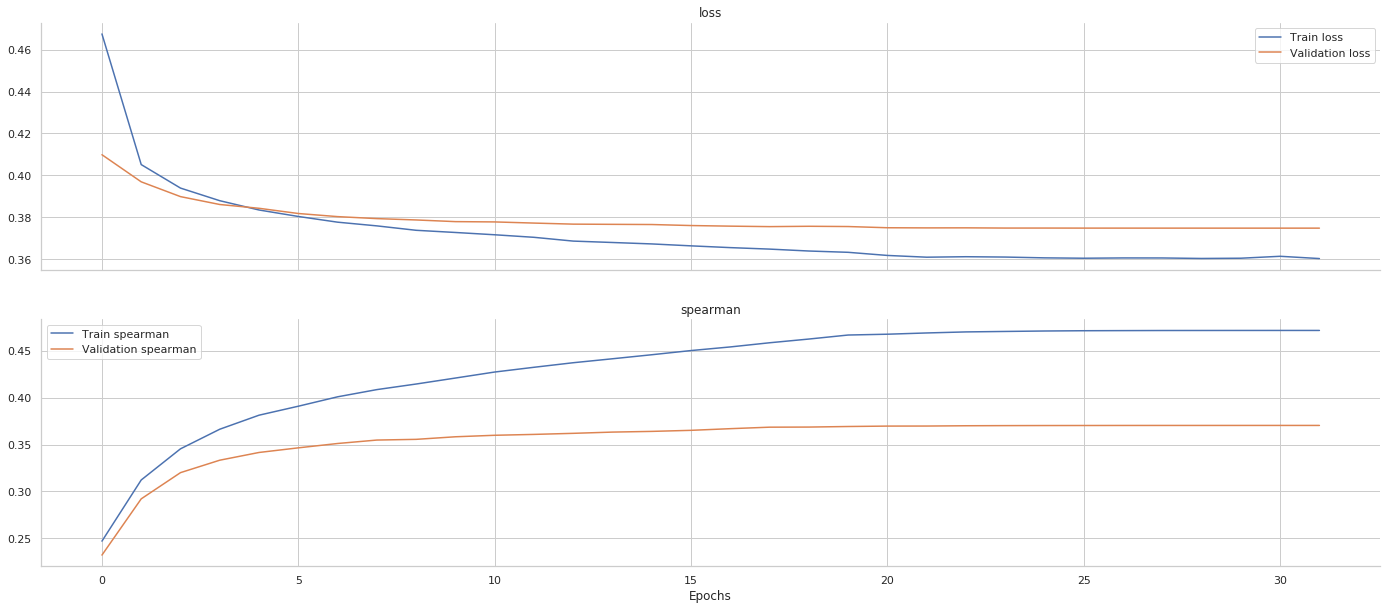

In [10]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [11]:
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))

,Label,Train,Validation
0,Averaged,0.472,0.370
1,question_asker_intent_understanding,0.451,0.405
2,question_body_critical,0.702,0.619
3,question_conversational,0.451,0.408
4,question_expect_short_answer,0.467,0.262
5,question_fact_seeking,0.484,0.332
6,question_has_commonly_accepted_answer,0.536,0.432
7,question_interestingness_others,0.448,0.399
8,question_interestingness_self,0.583,0.535
9,question_multi_intent,0.560,0.440


## By category

In [12]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

,Label,Train (TECHNOLOGY),Validation (TECHNOLOGY),Train (SCIENCE),Validation (SCIENCE),Train (STACKOVERFLOW),Validation (STACKOVERFLOW),Train (LIFE_ARTS),Validation (LIFE_ARTS),Train (CULTURE),Validation (CULTURE)
0,Averaged,0.436,0.333,0.481,0.367,0.369,0.196,0.498,0.407,0.494,0.38


#### Save model weights and ecoders

In [13]:
model.save_weights(model_path)